Notebook describes how to add event data. This can be achieved by rebinning or by removing TOF dimenssion. 
The distadvantage of the latter approach is that it will most likely be needed for making TOF mask data. 
It still is probably fine for nomivator

In [1]:
import scipp as sc
import scippneutron as scn
import mantid.simpleapi as mantid

FrameworkManager-[Notice] Welcome to Mantid 6.7.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.7
DownloadInstrument-[Notice] All instrument definitions up to date


In [46]:
def add_runs(runs, data_path): 
    """
    Adding data and monitors from different runs. Iterates over list of runs. 
    Currently returning two data sets, however it may also be possible to create one in order to use workflows
    """
    input_file1 = f'{data_path}/{runs[0]}-2022-02-28_2215.nxs'
    #fixed_file1 = f'{input_file1[:-4]}_fixed.nxs'
    data1 = scn.load_nexus(data_file=input_file1)
    da1 = data1.squeeze().copy()
    summed_data = da1
    summed_monitors_1 = da1.attrs['monitor_1'].value
    summed_monitors_2 = da1.attrs['monitor_2'].value
    #TODO: Should I take tof min and max and use it for setting boundaries

    start_tof = data1.coords['tof'][0].values
    end_tof = data1.coords['tof'][-1].values
    for run in runs[1:]: 
        print(f'Run: {run}')
        input_file2 = f'{data_path}/{run}-2022-02-28_2215.nxs'
        #fixed_file2 = f'{input_file2[:-4]}_fixed.nxs'
        data2 = scn.load_nexus(data_file=input_file2)
        if start_tof <  data2.coords['tof'][0].values:
            start_tof =  data1.coords['tof'][0].values
        if end_tof > data2.coords['tof'][-1].values:
            end_tof = data2.coords['tof'][-1].values
        da2 = data2.squeeze().copy()
        summed_data = summed_data.bins.concatenate(da2)
        summed_monitors_1 = summed_monitors_1.bins.concatenate(da2.attrs['monitor_1'].value)
        summed_monitors_2 = summed_monitors_2.bins.concatenate(da2.attrs['monitor_2'].value)

    edges=sc.linspace('tof', start_tof, end_tof, 2, unit='ns')
    summed_binned_data = sc.bin(summed_data, tof=edges)

    #Adding montors from first data set
    summed_binned_data.attrs['monitor_1'] = data1.attrs['monitor_1']
    summed_binned_data.attrs['monitor_2'] = data1.attrs['monitor_2']
    return summed_binned_data

In [47]:
#runs = ['60323', '60329', '60353']
runs = [60250, 60264, 60292, 60308, 60322, 60339, 60353, 60367, 60381, 60395]

In [48]:
data_path = '/Users/wojciechpotrzebowski/SCIPP_SPACE/loki_detector_test/2022-06-24_calibrated_nexus_files'

In [49]:
summed_data = add_runs(runs, data_path)

Run: 60264
Run: 60292
Run: 60308
Run: 60322
Run: 60339
Run: 60353
Run: 60367
Run: 60381
Run: 60395


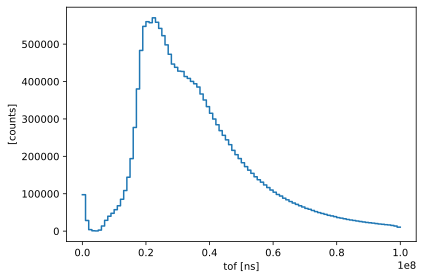

In [45]:
summed_data.hist(tof=100).sum('detector_id').plot() 

In [ ]:
#scn.instrument_view(binned_data.hist(tof=100))

### Comparison with mantid addition

In [ ]:
mantid_file_path = '/Users/wojciechpotrzebowski/SCIPP_SPACE/loki_detector_test/merged_files'
mantid_file_path = '/Users/wojciechpotrzebowski/SCIPP_SPACE/loki_detector_test/2022-06-24_calibrated_nexus_files'
mantid_file = scn.load(f'{mantid_file_path}/60395-mantid-add.nxs')

In [ ]:
monitors_mantid_file = scn.load(f'{mantid_file_path}/60395-monitors-add.nxs')

In [ ]:
edges_us=sc.to_unit(edges, unit='us')

In [ ]:
binned_mantid_data= sc.bin(mantid_file, edges=[edges_us])

In [ ]:
binned_mantid_data.sum('spectrum').plot()